In [2]:
from lxml import objectify
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [3]:
def plot(x,y=None):
    if y==None:
        tmp = range(len(x))
        y = x
        x = tmp
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(x,y)
    plt.show()

In [4]:
path=r'dataset/REFIT_BUILDING_SURVEY.xml'
tree = objectify.parse(path)
root = tree.getroot()
NS={'a':'http://www.refitsmarthomes.org'}

path=r'dataset/REFIT_TIME_SERIES_VALUES.csv'
csv=pd.read_csv(path, index_col=0, parse_dates=[1])

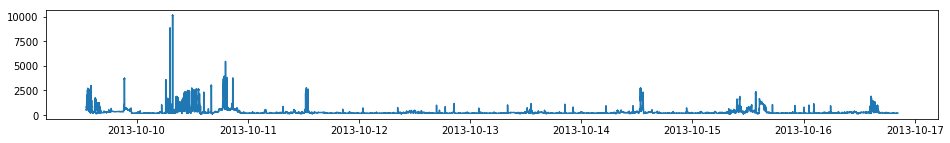

In [5]:
#Energy consumption in home
def get_energy():
    """
        Available only for 1st building, due to needs a lot of memory on drive
    """
    
    path = r'dataset/CLEAN_House1.csv'
    csvnrg=pd.read_csv(path, header=0,usecols=["Time", "Aggregate"], parse_dates=[0])

    data_en = csvnrg['Aggregate'].tolist()[:100000]
    time_en = csvnrg['Time'].tolist()[:100000]

    plot(time_en, data_en)
    
    return data_en, time_en

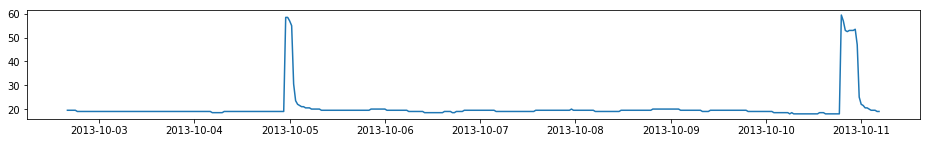

In [6]:
#Values of (gas based) Radiator temperature sensor
def get_radiator(building_num=1, rad_num=2):
    appliance = 'Radiator[%d]' % (rad_num)
    NS={'a':'http://www.refitsmarthomes.org'}
    
    radiators = root.xpath('./a:Stock/a:Building[%d]/a:%s' % (building_num, appliance), namespaces=NS)

    data_rad = []
    time_rad = []

    for rad in radiators:
        r_id = rad.get('id')
        t = []
        v = []
        for sensor in rad.getchildren():
            for time_series_variable in sensor.getchildren():
                id = time_series_variable.get('id')
                t.append(csv.loc[id]['dateTime'].tolist())
                v.append(csv.loc[id]['data'].values.tolist())
        data_rad = list(itertools.chain.from_iterable(v))
        time_rad = list(itertools.chain.from_iterable(t))
    
    return data_rad, time_rad

In [7]:
#Summs values for intervals

by_day = lambda t: t.day
by_week = lambda t: t.week
by_month = lambda t: t.month
    
act_sum = lambda s, vi: s + vi
act_max = lambda s, vi: max(s,vi)
act_min = lambda s, vi: min(s,vi)
    
def act_interval(check_param, action, times, values):
    t = []
    v = []
    s = values[0]
    for i in range(1, len(times)):
        if check_param(times[i]) == check_param(times[i-1]):
            s = action(s, values[i])
        else:
            v.append(s)
            t.append(times[i])
            s = values[i]
    return t,v

gas week usage


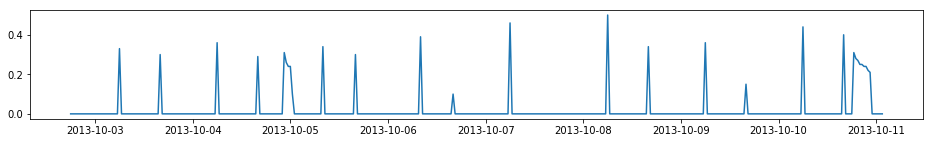

gas day sum usage


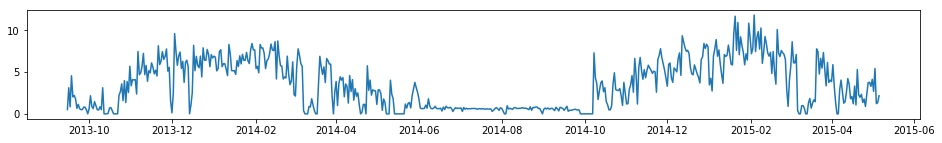

gas day sum FFT coefficients


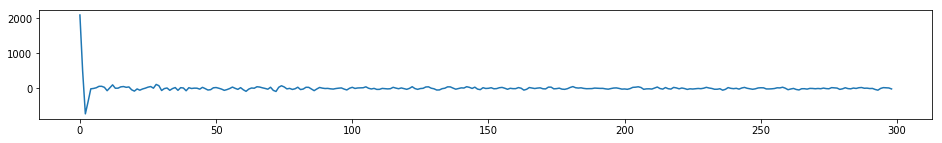

299

In [8]:
#Usage of gas in home

def get_gas(building_num=1):
    appliance = 1 #Number of gas meter
    NS={'a':'http://www.refitsmarthomes.org'}
    tsv = root.xpath('./a:Stock/a:Building[%d]/a:Meter[%d]/a:Sensor/a:TimeSeriesVariable' % (building_num, appliance), namespaces=NS)

    id = tsv[0].get('id')

    time_gas = csv.loc[id]['dateTime'].tolist()
    data_gas = csv.loc[id]['data'].values.tolist()
    
    time_gas, data_gas = act_interval(by_day, act_sum, time_gas, data_gas)
    
    return data_gas, time_gas


def get_fft(data):
    from numpy.fft import rfft
    fg = rfft(data).real
    print('gas day sum FFT coefficients')
    plot(fg)
    len(fg)
    
    return fg

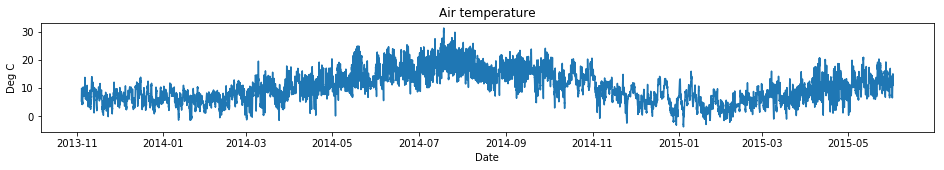

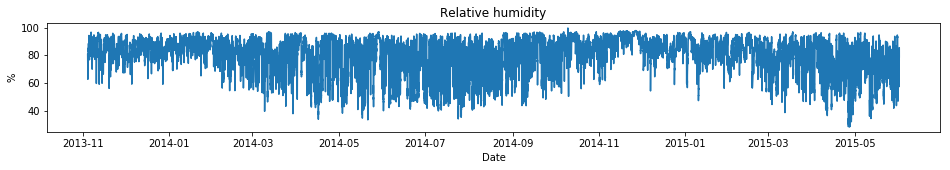

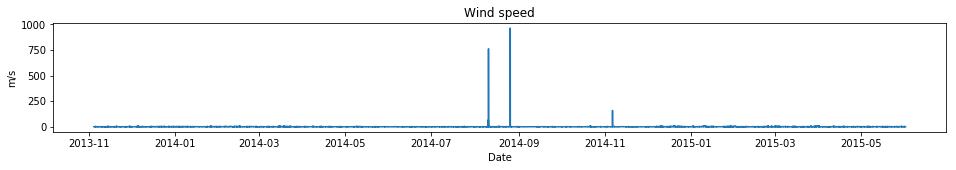

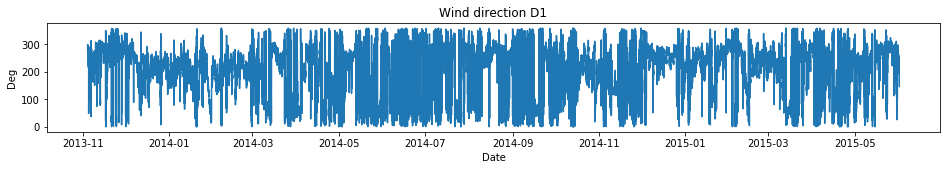

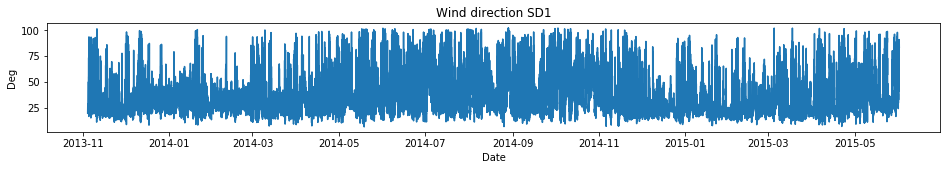

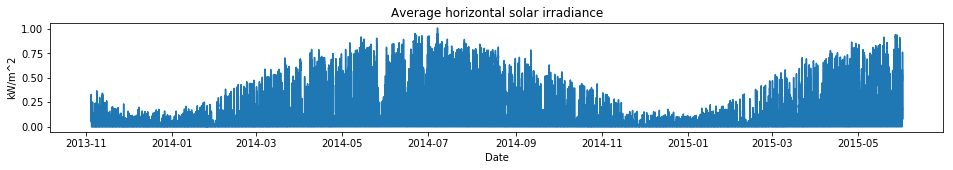

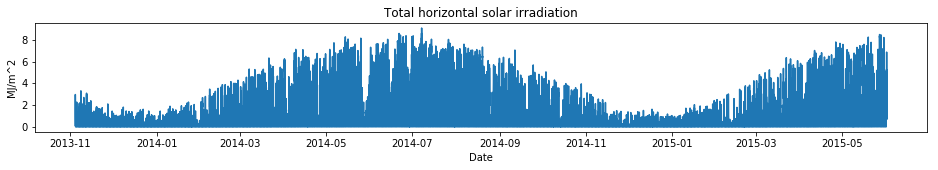

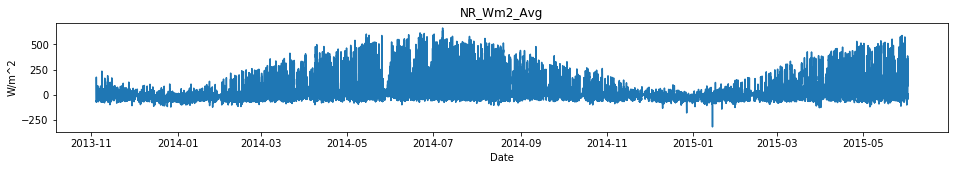

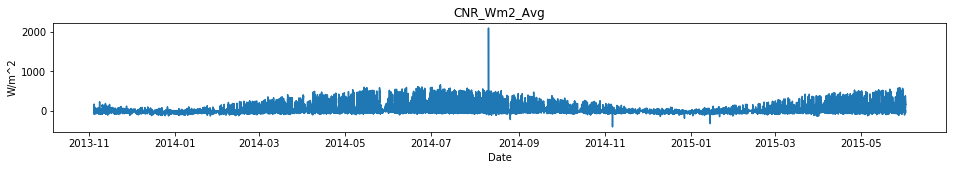

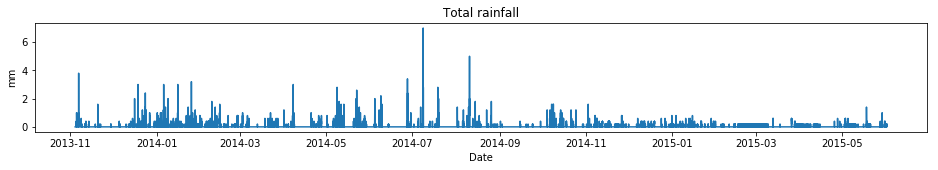

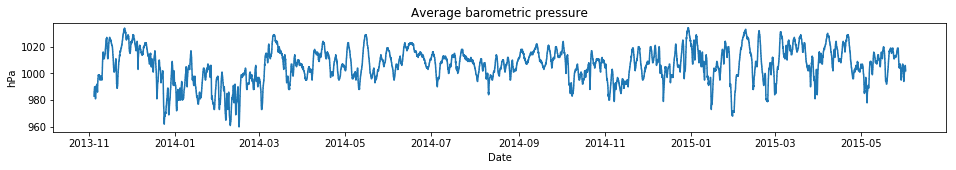

In [9]:
#Weather data 

NS={'a':'http://www.refitsmarthomes.org'}
elements=root.xpath('./a:Stock/a:Climate/a:Sensor/a:TimeSeriesVariable', namespaces=NS)
data_clim = []
time_clim = []
for e in elements:
    id = e.get('id')
    variable_type=e.get('variableType')
    units=e.get('units')
    fig, ax = plt.subplots(figsize=(16,2))
    ax.set_title(variable_type)
    ax.set_xlabel('Date')
    ax.set_ylabel(units)
    t,v = act_interval(by_day, act_min, csv.loc[id]['dateTime'].tolist(), csv.loc[id]['data'].tolist())
    data_clim.append(v)
    if len(time_clim) == 0:
        time_clim = t
    else: 
        assert len(time_clim) == len(t)
    ax.plot(csv.loc[id]['dateTime'],csv.loc[id]['data'])
    plt.show()

In [10]:
e = elements[0]
climate_sensors = []
for i in elements:
    climate_sensors.append(i.attrib['variableType'])
print(climate_sensors)
#indexes: 0, 1, 2, -2, -1

['Air temperature', 'Relative humidity', 'Wind speed', 'Wind direction D1', 'Wind direction SD1', 'Average horizontal solar irradiance', 'Total horizontal solar irradiation', 'NR_Wm2_Avg', 'CNR_Wm2_Avg', 'Total rainfall', 'Average barometric pressure']


# RNN (LSTM) building

In [11]:
#TODO: try LSTM model to predict gas consumption 

time_gas
data_gas

time_clim
data_clim

print(len(time_gas))
print(len(time_clim))


#TODO: сделать выравниваение универсальным

#align dates in intervals
#meter must be 7 days before now
#climate must begin day after now (tommorow)
gap = 7 #len (days before now) for FFT (for input layer of LSTM)
print(time_gas[gap])
print(time_clim[0])
begin = time_gas.index(time_clim[0]) - gap
time_gas = time_gas[begin:]
data_gas = data_gas[begin:]

end = time_clim.index(time_gas[-1]) + 1
time_clim = time_clim[:end]

print(len(time_gas))
print(len(time_clim))
print('first')
print(time_gas[gap])
print(time_clim[0])

print('last')
print(time_gas[-1])
print(time_clim[-1])

tmp = []
for d in data_clim:
    tmp.append(d[:end])
data_clim = tmp

597
574
2013-09-22 00:00:00
2013-11-05 00:00:00
553
548
first
2013-11-05 00:00:00
2013-11-05 00:00:00
last
2015-05-06 00:00:00
2015-05-06 00:00:00


In [12]:
#Prepare data to train LSTM

begin = 507
end = begin + gap

# plot(time_gas[begin:end], data_gas[begin:end])
fg = rfft(data_gas[begin:end]).real
# print('gas day sum FFT coefficients')
# plot(fg)
len(fg)

xinp = [] #Construct of 0-3: FFT coefficients, 4-weather forecast values on tommorow
ypred = []

for idx in range(gap, len(time_gas)-1):
    item = time_gas[idx]
    row = rfft(data_gas[idx-gap:idx]).real.tolist()
    ypred.append(data_gas[idx+1])
    #add weather forecast
    widx = time_clim.index(item) #weather's series index for current date
    row.append(data_clim[0][widx+1])
    row.append(data_clim[1][widx+1])
    row.append(data_clim[2][widx+1])
    row.append(data_clim[-2][widx+1])
    row.append(data_clim[-1][widx+1])
    
    xinp.append(row)

print(xinp[-1])
print(ypred[-1])
    
    

[24.17, -1.2203160045603454, -0.9628430605350609, 3.1531590650953962, 9.03, 52.23, 0.654, 0.0, 978.0]
2.15


In [13]:
#Store input and output
import pickle

saveAsText = False

if saveAsText:
    with open('inp.txt', 'w') as f:
        for i in xinp:
            f.write(', '.join(map(str, i)))
            f.write('\n')


    with open('out.txt', 'w') as f:
        for i in ypred:
            f.write(str(i))
            f.write('\n')
else:
    with open('inp.pkl', 'wb') as f:
        pickle.dump(xinp, f)
    with open('pred.pkl', 'wb') as f:
        pickle.dump(ypred, f)



# model begins here

In [14]:
#Load data
import pickle

with open('inp.pkl', 'rb') as f:
    x = pickle.load(f)
    
    
with open('pred.pkl', 'rb') as f:
    y = pickle.load(f)

In [15]:
#Train LSTM

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\Users\Ford\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:

dataframe = pandas.read_csv('inp.txt', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print(len(dataset))

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset):
    dataX = numpy.array(dataset)
    
    # reshape input to be [samples, time steps, features] (was [samples, features])
    dataX = numpy.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1])) 
    
    return dataX

trainX = create_dataset(train)
testX = create_dataset(test)



valframe = pandas.read_csv('out.txt', engine='python')
valset = valframe.values
valset = valset.astype('float32')

#Scale
scalerY = MinMaxScaler(feature_range=(0, 1))
valset = scalerY.fit_transform(valset)

trainY, testY = valset[0:train_size,:], valset[train_size:len(valset),:]
print(len(trainY), len(testY))


544
364 180
364 180


C:\Users\Ford\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
 - 8s - loss: 0.0586
Train Score: 2.19 RMSE
Test Score: 2.91 RMSE
Epoch 1/1
 - 3s - loss: 0.0229
Train Score: 1.55 RMSE
Test Score: 2.14 RMSE
Epoch 1/1
 - 3s - loss: 0.0171
Train Score: 1.49 RMSE
Test Score: 2.06 RMSE
Epoch 1/1
 - 3s - loss: 0.0163
Train Score: 1.45 RMSE
Test Score: 1.94 RMSE
Epoch 1/1
 - 3s - loss: 0.0156
Train Score: 1.46 RMSE
Test Score: 1.98 RMSE
Epoch 1/1
 - 3s - loss: 0.0153
Train Score: 1.42 RMSE
Test Score: 1.91 RMSE
Epoch 1/1
 - 3s - loss: 0.0149
Train Score: 1.40 RMSE
Test Score: 1.88 RMSE
Epoch 1/1
 - 3s - loss: 0.0148
Train Score: 1.42 RMSE
Test Score: 1.92 RMSE
Epoch 1/1
 - 3s - loss: 0.0144
Train Score: 1.48 RMSE
Test Score: 2.01 RMSE
Epoch 1/1
 - 3s - loss: 0.0146
Train Score: 1.41 RMSE
Test Score: 1.79 RMSE
Epoch 1/1
 - 3s - loss: 0.0144
Train Score: 1.47 RMSE
Test Score: 1.96 RMSE
Epoch 1/1
 - 3s - loss: 0.0144
Train Score: 1.38 RMSE
Test Score: 1.78 RMSE
Epoch 1/1
 - 3s - loss: 0.0143
Train Score: 1.38 RMSE
Test Score: 1.76 RMSE
Epoch 1/1
 -

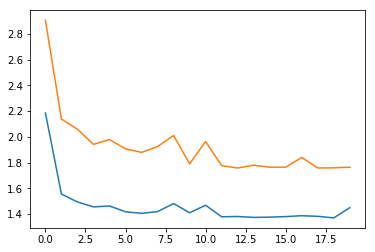

In [17]:
#design and fit our LSTM network

neurons = 10
epochs = 20

model = Sequential()
model.add(LSTM(neurons, input_shape=(1, trainX.shape[2]))) #,return_sequences=True
# model.add(LSTM(neurons))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)
tr = []
te = []
for i in range(epochs):
    history = model.fit(trainX, trainY, nb_epoch=1, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scalerY.inverse_transform(trainPredict)
    trY = scalerY.inverse_transform(trainY)
    testPredict = scalerY.inverse_transform(testPredict)
    teY = scalerY.inverse_transform(testY)
    # calculate root mean squared error
    tmp = mean_squared_error(trY, trainPredict[:,0])
    trainScore = math.sqrt(tmp)
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(teY, testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    tr.append(trainScore)
    te.append(testScore)
plt.plot(tr)
plt.plot(te)
plt.show()
    

In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict)
trainY = scalerY.inverse_transform(trainY)
testPredict = scalerY.inverse_transform(testPredict)
testY = scalerY.inverse_transform(testY)
# calculate root mean squared error
tmp = mean_squared_error(trainY, trainPredict[:,0])
trainScore = math.sqrt(tmp)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.45 RMSE
Test Score: 1.76 RMSE


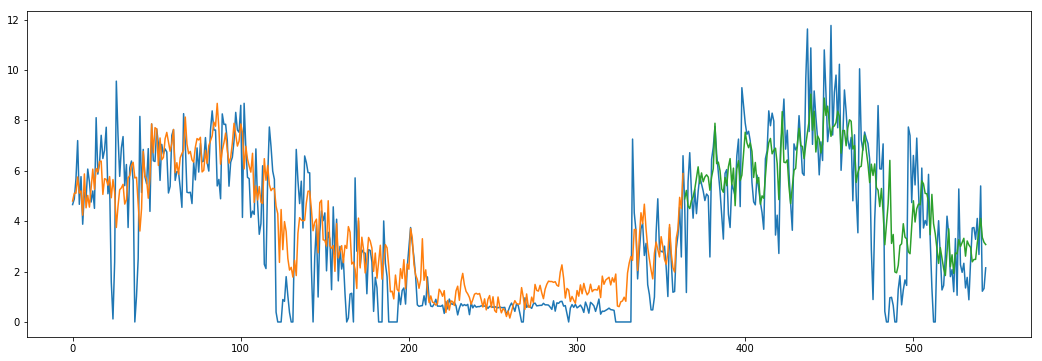

In [19]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(valset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(valset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(valset), :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(scalerY.inverse_transform(valset))
ax.plot(trainPredictPlot)
ax.plot(testPredictPlot)
plt.show()

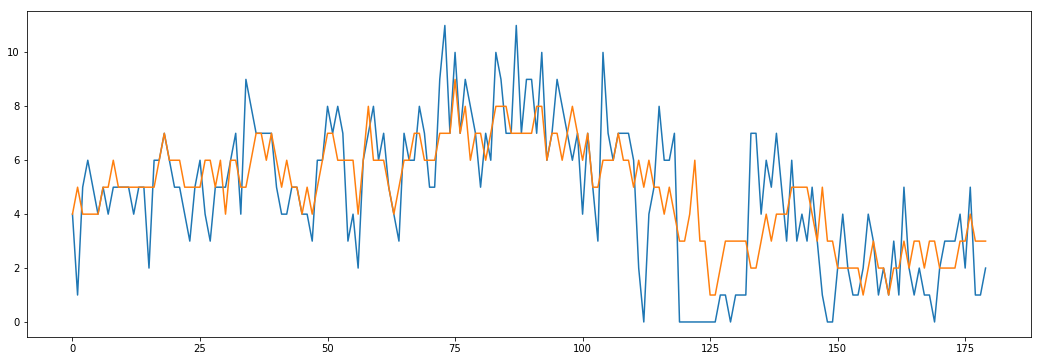

In [20]:
a = list(map(int, scalerY.inverse_transform(valset[len(trainPredict):])))
b = list(map(int, testPredict))
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(a)
ax.plot(b)
plt.show()